In [1]:
import xarray as xr
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import itertools as it
from glob import glob
from netCDF4 import Dataset
from matplotlib.cm import get_cmap
import gc

prefix = '20241031'
path_root = f'/gpfs/wolf2/cades/cli185/proj-shared/zdr/ERW/output/UQ/{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1/'
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'ensemble')

tuples = list(it.product(np.linspace(10, 1000, 10), np.linspace(2, 10, 10)))
tuples = [(1, 0)] + tuples
n_ens = len(tuples)

zsoi = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 2.8646])
zisoi = np.array([0.0175, 0.0451, 0.0906, 0.1655, 0.2891, 0.4929, 0.8289, 1.3828, 2.2961, 3.8019])
dzsoi = np.array([0.0175, 0.0276, 0.0455, 0.0750, 0.1236, 0.2038, 0.3360, 0.5539, 0.9133, 1.5058])

# minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
#                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
#                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
#                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
# normal alkali basalt (fast)
pct_basalt = np.array([0, 12, 0, 0, 0, 0, 43, 21, 6, 0])
# normal tholeiitic basalt (slow)
# pct_basalt = np.array([0, 0, 0, 0, 0, 0, 45, 34, 5, 3])

cation_names = ['Ca2+', 'Mg2+', 'Na+', 'K+', 'Al3+']

# 0. All four mineral's mass evolution over time

In [2]:
minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
mineral_list = [2, 7, 8, 9]

id = 2

primary_mineral_total = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = mineral_list
)
for year in range(2000, 2021):
    nc = Dataset(os.path.join(path_root, f'g{id:05d}', 
        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))
    # g m-2
    for min in mineral_list:
        ts = np.nansum(nc['primary_mineral'][0, min-1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        primary_mineral_total.loc[year, min] = ts
    nc.close()

    gc.collect()

In [4]:
# Temporal drawdown of mineral, in tonne over entire CONUS
fig, ax = plt.subplots(1, 1, figsize = [10, 8], sharex = True, sharey = True)
for min in mineral_list:
    ax.plot(primary_mineral_total.index[1:], 
            primary_mineral_total.loc[2001:, min] / 1000, '-o', label = minerals_name[min-1])
    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Size = {gra:.2f}, App = {app:.2f}')
    ax.set_ylabel('Remaining mineral (kg m-2)')
ax.legend(ncol = 5, loc = (0, -0.1))
plt.savefig(os.path.join(path_out, 'primary_mineral_all.png'), dpi = 600., bbox_inches = 'tight')
plt.close(fig)

# 1. Foresterite mass evolution over time

In [5]:
# foresterite
primary_mineral_total = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(2, n_ens+1)
)
for id in range(2, n_ens+1):
    for year in range(2000, 2021):
        nc = Dataset(os.path.join(path_root, f'g{id:05d}', 
            f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))
        # g m-2
        ts = np.nansum(nc['primary_mineral'][0, 1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        primary_mineral_total.loc[year, id] = ts
        nc.close()

        gc.collect()

In [6]:
# Temporal drawdown of mineral, in tonne over entire CONUS
cmap = get_cmap('Reds')
clist = [cmap((i-1.5)/(n_ens+1)) for i in range(2, n_ens+1)]
gra_list = []

fig, axes = plt.subplots(2, 5, figsize = [20, 10], sharex = True, sharey = True)
for id in range(2, n_ens + 1):
    # one application rate per subplot
    i = np.mod(id - 2, 10)
    ax = axes.flat[i]

    ax.plot(primary_mineral_total.index[1:], 
            primary_mineral_total.loc[2001:, id] / 1000, '-o', color = clist[id-2])

    #ax.plot(primary_mineral_ref.index[1:], primary_mineral_ref.loc[2001:], '-ob')
    if i == 0:
        gra_list.append( tuples[id-1][0] )
    app = tuples[id-1][1]
    ax.set_title(f'App = {app:.2f} (kg m-2 yr-1)')
    ax.set_ylabel('kg m-2')
ax = axes.flat[0]
ax.legend(gra_list, ncol = 5, loc = (0, -1.5))
plt.savefig(os.path.join(path_out, 'primary_mineral.png'), dpi = 600., bbox_inches = 'tight')
plt.close(fig)

/tmp/ipykernel_843283/3058519986.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


# 2. Dissolution rates over time

Weighted averaged over soil layers and grid cells

In [4]:
r_dissolve = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(2, n_ens+1)
)
for id in range(2, n_ens+1):
    for year in range(2000, 2021):
        nc = Dataset(os.path.join(path_root, f'g{id:05d}', 
            f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))

        # mol m-3 s-1 => mol m-2 s-1
        ts = np.nansum( \
            np.sum(nc['r_dissolve_vr_2'][0,:10,:] * dzsoi.reshape(-1, 1), axis = 0) * \
            nc['area'][:]) / np.sum(nc['area'][:])

        r_dissolve.loc[year, id] = ts

        nc.close()
        gc.collect()

In [5]:
# Temporal drawdown of mineral, in tonne over entire CONUS
cmap = get_cmap('Reds')
clist = [cmap((i-1.5)/(n_ens+1)) for i in range(2, n_ens+1)]

fig, axes = plt.subplots(2, 5, figsize = [20, 10], sharex = True, sharey = True)
for id in range(2, n_ens+1):
    # one application rate per subplot
    i = np.mod(id-2, 10)
    ax = axes.flat[i]

    # mol m-2 s-1 => mol m-2 yr-1
    ax.plot(r_dissolve.index[1:], 
            r_dissolve.loc[2001:, id] * 86400 * 365, '-o', color = clist[id-2])

    if i == 0:
        gra_list.append( tuples[id-1][0] )
    app = tuples[id-1][1]
    ax.set_title(f'App = {app:.2f} (kg m-2 yr-1)')
    ax.set_ylabel('mol m-2 yr-1')
ax = axes.flat[0]
ax.legend(gra_list, ncol = 5, loc = (0, -1.5))
plt.savefig(os.path.join(path_out, 'r_dissolve.png'), dpi = 600., bbox_inches = 'tight')
plt.close(fig)

/tmp/ipykernel_2693395/1305284021.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


# 3. Spatial map of cation flux due to mineral dissolution

In [6]:
year = 2001

In [18]:
icat = 2 # Mg2+
mass = 24

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        # gC m-2 s-1 => ton ha-1 year-1
        c = hr['primary_cation_flux'][0, icat-1, :].values/mass * 1e-6 * 1e4 * 86400 * 365, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Primary Mg2+ flux (ton ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'primary_cation_flux_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [8]:
icat = 2 # Mg2+
mass = 24

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    # gC m-2 s-1 => million meq ha-1 year-1
    data = hr[f'cec_cation_flux_vr_{icat}'][0, :10, :].values / mass * 1e-6 * 1e4 * 86400 * 365
    data = np.sum(data * dzsoi[:10].reshape(-1, 1), axis = 0)

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        c = data, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'CEC Mg2+ flux (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'cec_cation_flux_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [10]:
icat = 2 # Mg2+
mass = 24

hr = xr.open_dataset(
    os.path.join(path_root, f'g00001', 
                f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
)
data_ref = hr[f'cec_cation_flux_vr_{icat}'][0, :10, :].values / mass * 1e-6 * 1e4 * 86400 * 365
data_ref = np.sum(data_ref * dzsoi[:10].reshape(-1, 1), axis = 0)
hr.close()


fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    # gC m-2 s-1 => million meq ha-1 year-1
    data = hr[f'cec_cation_flux_vr_{icat}'][0, :10, :].values / mass * 1e-6 * 1e4 * 86400 * 365
    data = np.sum(data * dzsoi[:10].reshape(-1, 1), axis = 0)

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        c = data - data_ref, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'CEC Mg2+ flux minus reference (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'cec_cation_flux_delta_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [11]:
icat = 2 # Mg2+
mass = 24

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        # gC m-2 s-1 => 1e6 meq ha-1 year-1
        c = hr['background_flux'][0, icat-1, :].values/mass * 1e-6 * 1e4 * 86400 * 365, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Background Mg2+ flux (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'background_cation_flux_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [14]:
icat = 2 # Mg2+
mass = 24

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        # gC m-2 s-1 => ton ha-1 year-1
        c = hr['background_cec'][0, icat-1, :].values / mass * 1e-6 * 1e4 * 86400 * 365, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Background Mg2+ flux into CEC (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'background_cation_flux_cec_{year}.png'), 
            dpi = 600., bbox_inches = 'tight')
plt.close(fig)

In [13]:
icat = 2 # Mg2+
mass = 24

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        # gC m-2 s-1 => ton ha-1 year-1
        c = hr['cation_leached'][0, icat-1, :].values / mass * 1e-6 * 1e4 * 86400 * 365, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Leached Mg2+ flux (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'leach_cation_flux_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [17]:
icat = 2 # Mg2+
mass = 24

hr = xr.open_dataset(
    os.path.join(path_root, f'g00001', 
                f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
)
data_ref = hr['cation_leached'][0, icat-1, :].values/mass * 1e-6 * 1e4 * 86400 * 365
hr.close()

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        # gC m-2 s-1 => ton ha-1 year-1
        c = hr['cation_leached'][0, icat-1, :].values/mass * 1e-6 * 1e4 * 86400 * 365 - data_ref, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Leached Mg2+ flux (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'leach_cation_flux_delta_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [16]:
icat = 2 # Mg2+
mass = 24

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    # gC m-2 s-1 => ton ha-1 year-1
    data = hr['cation_infl_vr_2'][0, :10, :].values/mass * 1e-6 * 1e4 * 86400 * 365
    data = np.sum(data * dzsoi[:10].reshape(-1, 1), axis = 0)

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        c = data, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Vertical Mg2+ flux (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'infl_cation_flux_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [30]:
icat = 2 # Mg2+
mass = 24

hr = xr.open_dataset(
    os.path.join(path_root, f'g00001', 
                f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
)
# gC m-2 s-1 => ton ha-1 year-1
data = hr[f'cation_infl_vr_{icat}'][0, :10, :].values/mass * 1e-6 * 1e4 * 86400 * 365
data_ref = np.sum(data * dzsoi[:10].reshape(-1, 1), axis = 0)
hr.close()

fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    # gC m-2 s-1 => ton ha-1 year-1
    data = hr['cation_infl_vr_2'][0, :10, :].values * 1e-6 * 1e4 * 86400 * 365
    data = np.sum(data * dzsoi[:10].reshape(-1, 1), axis = 0)

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        c = data - data_ref, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Vertical Mg2+ flux (ton ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'infl_cation_flux_delta_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

In [19]:
icat = 2 # Mg2+
mass = 24

# Balance between leaching, cation_infl, and cec flux into the solution
fig, axes = plt.subplots(5, 4, figsize = [20, 20])

for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-0.25, 0.25, 41), ncolors=256)

    ax = axes.flat[i]

    # gC m-2 s-1 => 1e6 meq ha-1 year-1
    data1 = hr['cation_leached'][0, icat-1, :].values/mass * 1e-6 * 1e4 * 86400 * 365
    data2 = hr[f'cation_infl_vr_{icat}'][0, :10, :].values/mass * 1e-6 * 1e4 * 86400 * 365
    data2 = np.sum(data2 * dzsoi[:10].reshape(-1, 1), axis = 0)
    data3 = hr[f'cec_cation_flux_vr_{icat}'][0, :10, :].values/mass * 1e-6 * 1e4 * 86400 * 365
    data3 = np.sum(data3 * dzsoi[:10].reshape(-1, 1), axis = 0)

    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        c = data3 + data2 - data1, 
        cmap = 'Spectral', norm = norm
    )

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

    hr.close()

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, label = 'Balance between flow out of CEC, vertical drain, and horizontal leaching of Mg2+ flux (1e6 meq ha-1 yr-1)')
plt.savefig(os.path.join(path_out, f'budget_cation_flux_{year}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

# 4. Spatial map of accumulated carbon sequestration

In [9]:
for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    fig, axes = plt.subplots(5, 4, figsize = [20, 20])

    for j, year in enumerate(range(2001, 2021)):

        hr = xr.open_dataset(
            os.path.join(path_root, f'g00001', 
                        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
        )
        # gC m-2 s-1 => ton C ha-1 s-1
        r_benchmark = hr['r_sequestration'][0, :].values * 1e-6 * 1e4 * 86400 * 365
        hr.close()

        hr = xr.open_dataset(
            os.path.join(path_root, f'g{id:05d}', 
                        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
        )

        norm = BoundaryNorm(boundaries = np.linspace(-0.3, 0.3, 21), ncolors=256)

        ax = axes.flat[j]

        # gC m-2 s-1 => ton C ha-1 s-1
        new_data = hr['r_sequestration'][0, :].values * 1e-6 * 1e4 * 86400 * 365
        new_data = new_data - r_benchmark

        if year == 2001:
            accumulated = new_data
        else:
            accumulated = accumulated + new_data

        cf = ax.scatter(
            x = hr['lon'], y = hr['lat'], s = 11, 
            c = accumulated, 
            cmap = 'Spectral', norm = norm
        )

        gra = tuples[id-1][0]
        app = tuples[id-1][1]

        # note: 1 kg/m2 = 10 ton/ha
        ax.set_title(year)

        hr.close()

    fig.suptitle(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
    cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
    plt.colorbar(cf, cax = cax, label = 'Cumulative sequestration (ton C ha-1)')
    plt.savefig(os.path.join(path_out, f'r_sequestration_{id}.png'), dpi = 600., 
                bbox_inches = 'tight')
    plt.close(fig)

# 5. Spatial map of accumulated carbon sequestration based on HCO3- and CO3 2- flux

In [21]:
for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):

    fig, axes = plt.subplots(5, 4, figsize = [20, 20])

    for year in [2010, 2019]:

        hr = xr.open_dataset(
            os.path.join(path_root, f'g00001', 
                        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
        )
        # g m-3 => mol m-3
        bicarb_benchmark = np.sum((hr['bicarbonate_vr'][0,:10,:] / 61.0174 + \
                                hr['carbonate_vr'][0, :10, :] / 60.0100) * \
                                zsoi[:10].reshape(-1,1), axis = 0)
        hr.close()

        hr = xr.open_dataset(
            os.path.join(path_root, f'g{id:05d}', 
                        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
        )

        norm = BoundaryNorm(boundaries = np.linspace(-0.02, 0.02, 21), ncolors=256)

        ax = axes.flat[i]

        # g m-3 => mol m-3 => gC m-3
        bicarb_new = np.sum((hr['bicarbonate_vr'][0,:10,:] / 61.0174 + \
                            hr['carbonate_vr'][0, :10, :] / 60.0100) * \
                            zsoi[:10].reshape(-1,1), axis = 0)

        cf = ax.scatter(
            x = hr['lon'], y = hr['lat'], s = 11,
            c = bicarb_new - bicarb_benchmark,
            cmap = 'Spectral', norm = norm
        )

        gra = tuples[id-1][0]
        app = tuples[id-1][1]

        # note: 1 kg/m2 = 10 ton/ha
        ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

        hr.close()

    cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
    plt.colorbar(cf, cax = cax, label = 'Total HCO3- + CO3 2- (mol m-2)')
    plt.savefig(os.path.join(path_out, f'bicarbonate_{year}.png'), dpi = 600., 
                bbox_inches = 'tight')
    plt.close(fig)

In [22]:
for year in range(2001, 2020):

    hr = xr.open_dataset(
        os.path.join(path_root, f'g00001', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    # mm/s => m/s
    qdrai = hr['QDRAI'] * hr['H2OSOI'][0, :10, :] / hr['H2OSOI'][0, :10, :].sum(axis = 1)
    qdrai = qdrai[0, :, :].transpose('lndgrid','levgrnd')

    # mol m-3 soil / (m3 water m-3 soil) => mol m-3 water
    bicarb_temp = (hr['bicarbonate_vr'][0, :10, :] / 61.0174 + \
                   hr['carbonate_vr'][0, :10, :] / 60.0100) / hr['H2OSOI'][0, :10, :]
    # mol m-3 water * m3 water m-2 ground s-1 => mol m-2 s-1
    bicarb_flux = bicarb_temp * qdrai * 1e-3

    # mol m-3 soil / (m3 water m-3 soil) => mol m-3 water
    bicarb_temp = (hr['bicarbonate_vr'][0, 9, :] / 61.0174 + \
                   hr['carbonate_vr'][0, 9, :] / 60.0100) / hr['H2OSOI'][0, 9, :]
    # mol m-3 water * m3 water m-2 ground s-1 => mol m-2 s-1
    bicarb_vert = bicarb_temp * hr['QOUT'][0, 9, :] * 1e-3

    # mol m-2 s-1 => gC m-2 year-1
    bicarb_benchmark = (bicarb_flux.sum(axis = 0) + bicarb_vert) * 12 * 86400 * 365

    hr.close()

    fig, axes = plt.subplots(5, 4, figsize = [20, 20])

    for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
        hr = xr.open_dataset(
            os.path.join(path_root, f'g{id:05d}', 
                        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
        )

        norm = BoundaryNorm(boundaries = np.linspace(-3, 3, 21), ncolors=256)

        ax = axes.flat[i]

        # mm/s => m/s
        qdrai = hr['QDRAI'] * hr['H2OSOI'][0, :10, :] / hr['H2OSOI'][0, :10, :].sum(axis = 1)
        qdrai = qdrai[0, :, :].transpose('lndgrid','levgrnd')

        # mol m-3 soil / (m3 water m-3 soil) => mol m-3 water
        bicarb_temp = (hr['bicarbonate_vr'][0, :10, :] / 61.0174 + \
                    hr['carbonate_vr'][0, :10, :] / 60.0100) / hr['H2OSOI'][0, :10, :]
        # mol m-3 water * m3 water m-2 ground s-1 => mol m-2 s-1
        bicarb_flux = bicarb_temp * qdrai * 1e-3

        # mol m-3 soil / (m3 water m-3 soil) => mol m-3 water
        bicarb_temp = (hr['bicarbonate_vr'][0, 9, :] / 61.0174 + \
                       hr['carbonate_vr'][0, 9, :] / 60.0100) / hr['H2OSOI'][0, 9, :]
        # mol m-3 water * m3 water m-2 ground s-1 => mol m-2 s-1
        bicarb_vert = bicarb_temp * hr['QOUT'][0, 9, :] * 1e-3

        # mol m-2 s-1 => gC m-2 year-1
        bicarb_new = (bicarb_flux.sum(axis = 0) + bicarb_vert) * 12 * 86400 * 365

        if i == 0:
            accumulated = bicarb_new - bicarb_benchmark
        else:
            accumulated = accumulated + bicarb_new - bicarb_benchmark

        cf = ax.scatter(
            x = hr['lon'], y = hr['lat'], s = 11, 
            c = accumulated, 
            cmap = 'Spectral', norm = norm
        )

        gra = tuples[id-1][0]
        app = tuples[id-1][1]

        # note: 1 kg/m2 = 10 ton/ha
        ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

        hr.close()

    cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
    plt.colorbar(cf, cax = cax, label = 'Cumulative (HCO3- + CO3 2-) sequestration (ton C ha-1)')
    plt.savefig(os.path.join(path_out, f'r_sequestration_CO3_{year}.png'), dpi = 600., 
                bbox_inches = 'tight')
    plt.close(fig)

# 6. Spatial map of soil pH change

In [23]:
for year in range(2001, 2020):

    hr = xr.open_dataset(
        os.path.join(path_root, f'g00001', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )
    pH_benchmark = np.mean(hr['soil_pH'][0, :6, :].values * zsoi[:6].reshape(-1,1), axis = 0)
    hr.close()

    fig, axes = plt.subplots(5, 4, figsize = [20, 20])

    for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
        hr = xr.open_dataset(
            os.path.join(path_root, f'g{id:05d}', 
                        f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
        )

        norm = BoundaryNorm(boundaries = np.linspace(-0.1, 0.1, 21), ncolors=256)

        ax = axes.flat[i]

        new_data = np.mean(hr['soil_pH'][0, :6, :].values * zsoi[:6].reshape(-1,1), axis = 0)
        new_data = new_data - pH_benchmark

        cf = ax.scatter(
            x = hr['lon'], y = hr['lat'], s = 11, 
            c = new_data, 
            cmap = 'Spectral', norm = norm
        )

        gra = tuples[id-1][0]
        app = tuples[id-1][1]

        # note: 1 kg/m2 = 10 ton/ha
        ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')

        hr.close()

    cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
    plt.colorbar(cf, cax = cax, label = '$\Delta$ soil pH (top 6 layers)')
    plt.savefig(os.path.join(path_out, f'soil_pH_{year}.png'), dpi = 600., 
                bbox_inches = 'tight')
    plt.close(fig)

# 7. Spatial map of cation exchange pool size change

In [24]:
id = 2
fig, axes = plt.subplots(6, 4, figsize = [17, 20])
for i, year in enumerate([2001, 2007, 2013, 2019]):
    hr_ref = xr.open_dataset(
        os.path.join(path_root, f'g00001', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    hr = xr.open_dataset(
        os.path.join(path_root, f'g{id:05d}', 
                    f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc')
    )

    norm = BoundaryNorm(boundaries = np.linspace(-30, 30, 21), ncolors=256)

    ax = axes[0, i]
    proton_benchmark = hr_ref['cec_proton'][0, :].values
    proton_id = hr['cec_proton'][0, :].values
    cf = ax.scatter(
        x = hr['lon'], y = hr['lat'], s = 11, 
        c = proton_id - proton_benchmark, 
        cmap = 'Spectral', norm = norm
    )
    ax.set_title(f'H+ {year}')

    for icat in range(1, 6):
        ax = axes[icat, i]

        cec_benchmark = np.sum(hr_ref[f'cec_cation_vr_{icat}'][0, :10, :].values * \
                               zsoi.reshape(-1,1), axis = 0)
        cec_id = np.sum(hr[f'cec_cation_vr_{icat}'][0, :10, :].values * \
                        zsoi.reshape(-1,1), axis = 0)

        cf = ax.scatter(
            x = hr['lon'], y = hr['lat'], s = 11, 
            c = cec_id - cec_benchmark, 
            cmap = 'Spectral', norm = norm
        )

        ax.set_title(f'{cation_names[icat-1]} {year}')

    hr.close()
    hr_ref.close()

gra = tuples[id-1][0]
app = tuples[id-1][1]
# note: 1 kg/m2 = 10 ton/ha

cax = fig.add_axes([0.02, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, 
             label = '$\Delta$ CEC (ton ha-1), ' + f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
plt.savefig(os.path.join(path_out, f'cec_ensemble{id}.png'), dpi = 600., 
            bbox_inches = 'tight')
plt.close(fig)

# 8. Budget diagnostics

In [10]:
# Mg^2+
icat = 2
mass = 24

background_flux = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(1, n_ens)
)
dissolve_flux = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(1, n_ens)
)
precip_flux = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(1, n_ens)
)
cec_flux = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(1, n_ens)
)
leach_flux = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(1, n_ens)
)
infl_flux = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(1, n_ens)
)
for id in range(1, n_ens):
    for year in range(2000, 2021):
        nc = Dataset(os.path.join(path_root, f'g{id:05d}', 
            f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))

        # g m-2 s-1 => 1e6 meq ha-1 yr-1

        ts = np.nansum(nc['background_flux'][0, icat-1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        background_flux.loc[year, id] = ts / mass * 1e-6 * 1e4 * 86400 * 365

        ts = np.nansum(nc['secondary_cation_flux'][0, icat-1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        precip_flux.loc[year, id] = ts / mass * 1e-6 * 1e4 * 86400 * 365

        ts = np.nansum(nc['primary_cation_flux'][0, icat-1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        dissolve_flux.loc[year, id] = ts / mass * 1e-6 * 1e4 * 86400 * 365

        ts = np.nansum(nc['cec_cation_flux'][0, icat-1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        cec_flux.loc[year, id] = ts / mass * 1e-6 * 1e4 * 86400 * 365

        ts = np.nansum(nc['cation_leached'][0, icat-1, :] * nc['area'][:]) / np.sum(nc['area'][:])
        leach_flux.loc[year, id] = ts / mass * 1e-6 * 1e4 * 86400 * 365

        ts = np.nansum( \
            np.nansum( nc[f'cation_infl_vr_{icat}'][0, :10, :] * zsoi[:10].reshape(-1, 1),
                       axis = 0 ) * nc['area'][:] ) / np.sum(nc['area'][:])
        infl_flux.loc[year, id] = ts / mass * 1e-6 * 1e4 * 86400 * 365

        nc.close()

        gc.collect()

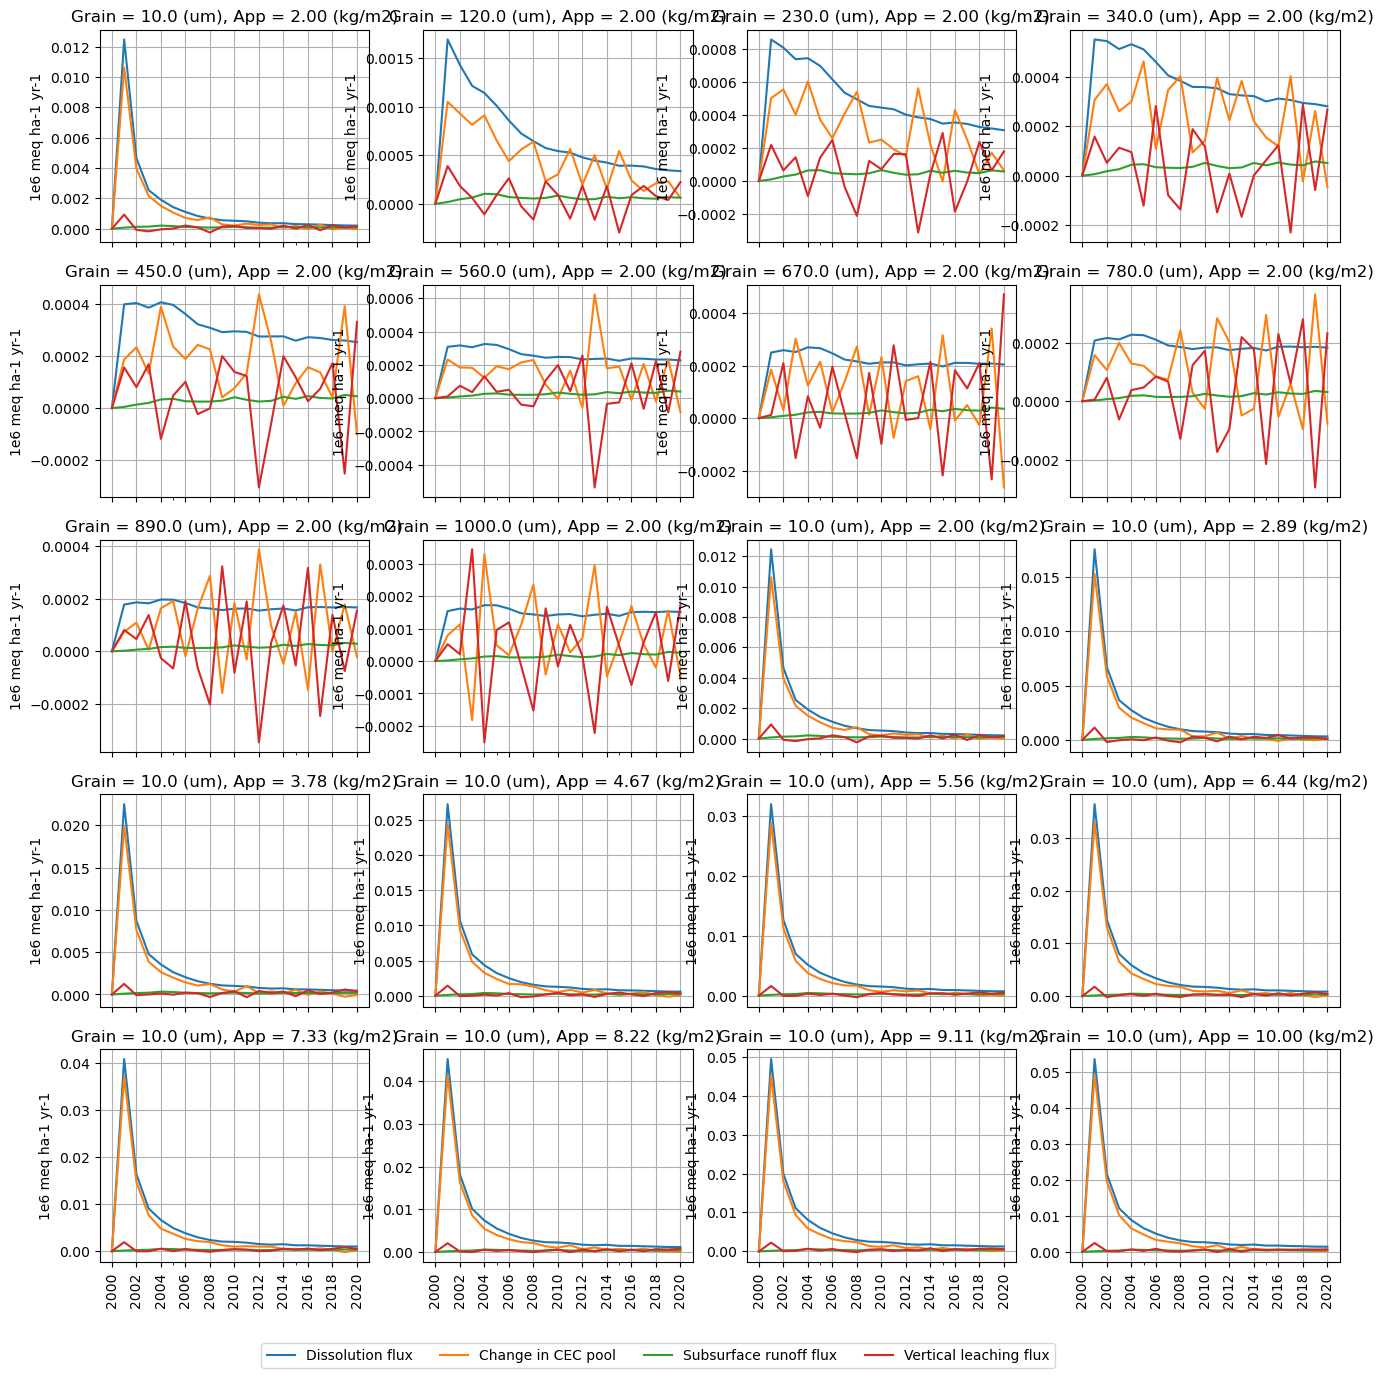

In [11]:
ref = 1

fig, axes = plt.subplots(5, 4, figsize = (16, 16), sharex = True, sharey = False)
for i, id in enumerate(list( range(2, n_ens+1, 10) ) + list( range(2, 12) )):
    ax = axes.flat[i]

    df = pd.DataFrame({
        'Dissolution flux': dissolve_flux.loc[:, id] - dissolve_flux.loc[:, ref], 
        'Change in CEC pool': - (cec_flux.loc[:, id] - cec_flux.loc[:, ref]),
        'Subsurface runoff flux': leach_flux.loc[:, id] - leach_flux.loc[:, ref], 
        'Vertical leaching flux': -(infl_flux.loc[:, id] - infl_flux.loc[:, ref])
    })
    df.plot(ax=ax, legend = False)
    ax.set_ylabel('1e6 meq ha-1 yr-1')
    ax.set_xticks(dissolve_flux.index[::2])
    ax.set_xticklabels(dissolve_flux.index[::2], rotation = 90)
    ax.grid(True)

    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.set_title(f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
ax.legend(ncol = 4, loc = [-3, -0.5])

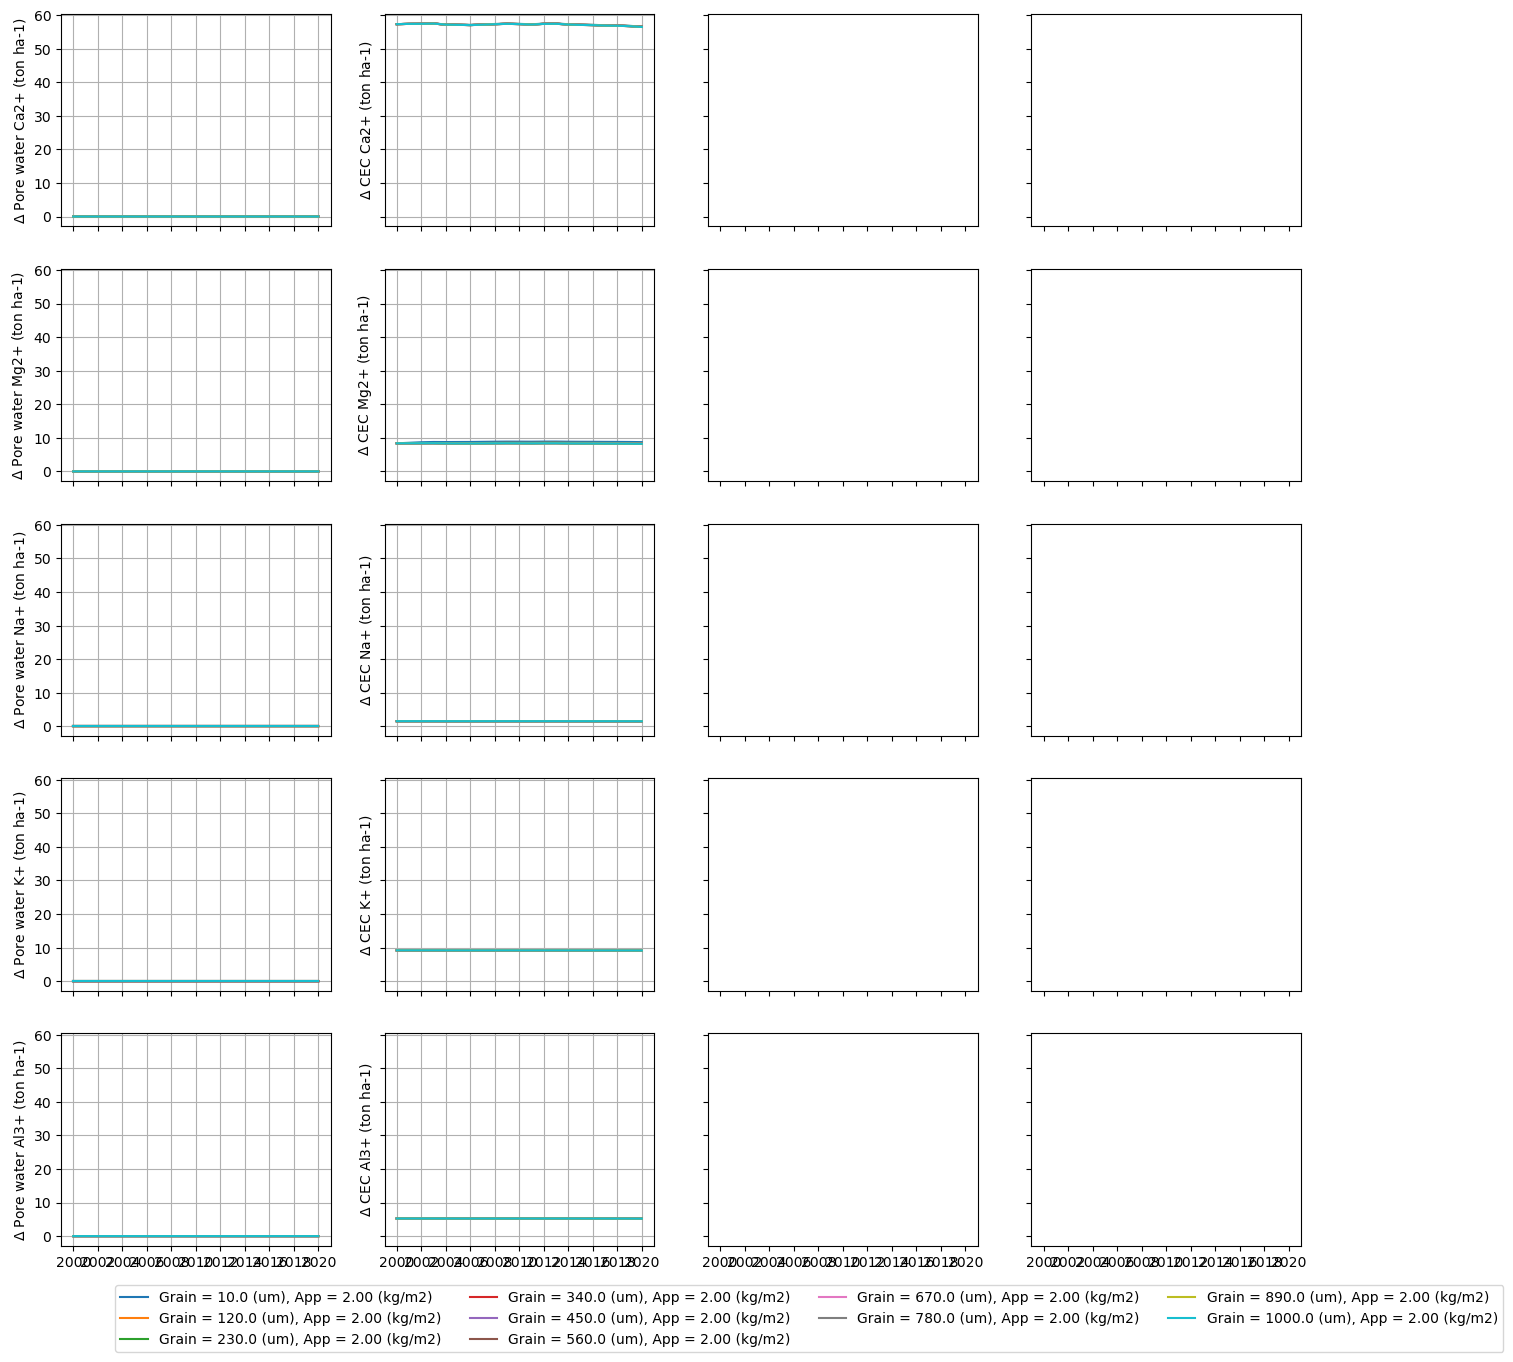

In [27]:
# Pore water and CEC pool sizes
ref = 1

fig, axes = plt.subplots(5, 4, figsize = (16, 16), sharex = True, sharey = True)

for icat in range(1, 6):

    pore_water_pool = pd.DataFrame(
        np.nan, index = range(2000, 2021), columns = range(2, n_ens+1)
    )
    cec_pool = pd.DataFrame(
        np.nan, index = range(2000, 2021), columns = range(2, n_ens+1)
    )
    for id in range(2, n_ens+1):
        for year in range(2000, 2021):
            nc_ref = Dataset(os.path.join(path_root, f'g00001', 
                f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))
            nc = Dataset(os.path.join(path_root, f'g{id:05d}', 
                f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))

            # g m-2 => ton ha-1
            ts = np.nansum((nc['cation'][0, icat-1, :] - nc_ref['cation'][0, icat-1, :]) * \
                           nc['area'][:]) / np.sum(nc['area'][:])
            pore_water_pool.loc[year, id] = ts * 1e-6 * 1e4

            ts = np.nansum((nc['cec_cation'][0, icat-1, :] - nc_ref['cation'][0, icat-1,:]) * \
                           nc['area'][:]) / np.sum(nc['area'][:])
            cec_pool.loc[year, id] = ts * 1e-6 * 1e4

            nc.close()
            nc_ref.close()
            gc.collect()

    ax = axes[icat - 1, 0]
    for i, id in enumerate(range(2, n_ens+1, 10)):
        gra = tuples[id-1][0]
        app = tuples[id-1][1]
        ax.plot(pore_water_pool.index, 
                pore_water_pool.loc[:, id], 
                label = f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
    ax.set_ylabel('$\Delta$ Pore water ' + cation_names[icat-1] + ' (ton ha-1)')
    ax.set_xticks(pore_water_pool.index[::2])
    ax.grid(True)
    #ax.legend()

    ax = axes[icat - 1, 1]
    for i, id in enumerate(range(2, n_ens+1, 10)):
        gra = tuples[id-1][0]
        app = tuples[id-1][1]
        ax.plot(cec_pool.index, 
                cec_pool.loc[:, id], 
                label = f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
    ax.set_ylabel('$\Delta$ CEC ' + cation_names[icat-1] + ' (ton ha-1)')
    ax.set_xticks(cec_pool.index[::2])
    ax.grid(True)
ax.legend(ncol = 4, loc = [-1, -0.5])

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


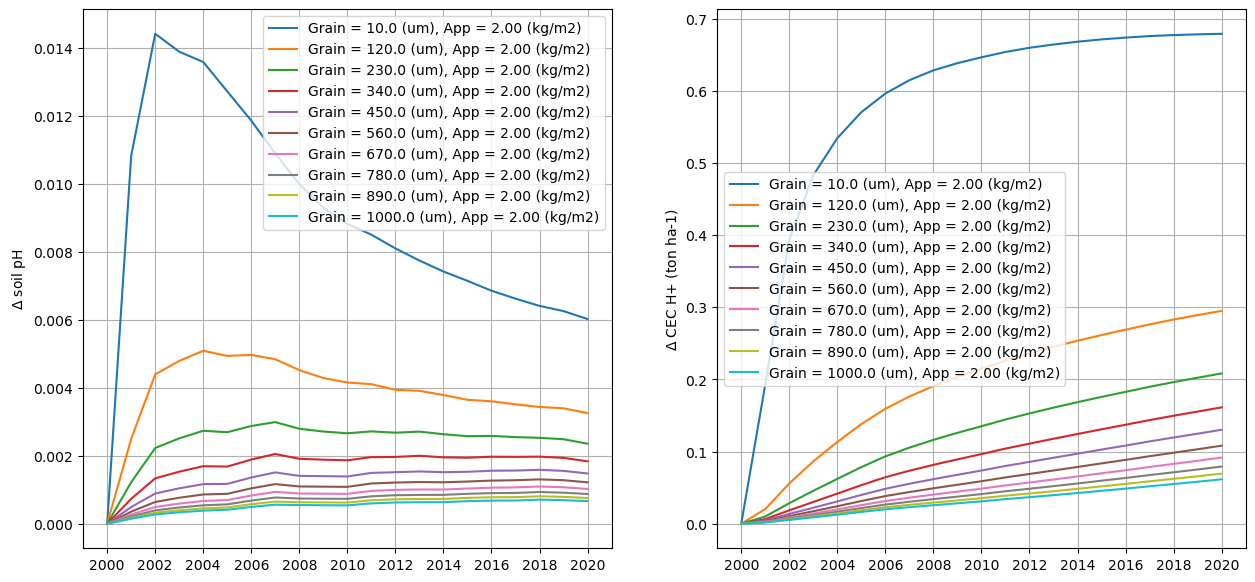

In [28]:
ref = 1

# soil pH and CEC H+
soil_ph = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(2, n_ens+1)
)
cec_proton = pd.DataFrame(
    np.nan, index = range(2000, 2021), columns = range(2, n_ens+1)
)
for id in range(2, n_ens+1):
    for year in range(2000, 2021):
        nc_ref = Dataset(os.path.join(path_root, f'g00001', 
            f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))
        nc = Dataset(os.path.join(path_root, f'g{id:05d}', 
            f'{prefix}_conus_ICB20TRCNPRDCTCBC_erw_pft1.elm.h0.{year}-01-01-00000.nc'))

        # g m-2 => ton ha-1
        # subtract the reference first, then deduct
        ts = np.nansum((nc['soil_pH'][0, :] - nc_ref['soil_pH'][0,:]) * nc['area'][:] \
                       ) / np.sum(nc['area'][:])
        soil_ph.loc[year, id] = ts * 1e-6 * 1e4

        ts = np.nansum((nc['cec_proton'][0, :] - nc_ref['cec_proton'][0,:]) * nc['area'][:] \
                       ) / np.sum(nc['area'][:])
        cec_proton.loc[year, id] = ts * 1e-6 * 1e4

        nc.close()
        nc_ref.close()
        gc.collect()


fig, axes = plt.subplots(1, 2, figsize = (15, 7), sharex = True, sharey = False)

ax = axes.flat[0]
for i, id in enumerate(range(2, n_ens+1, 10)):
    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.plot(soil_ph.index, 
            soil_ph.loc[:, id], 
            label = f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
ax.set_ylabel('$\Delta$ soil pH')
ax.set_xticks(cec_proton.index[::2])
ax.grid(True)
ax.legend()

ax = axes.flat[1]
for i, id in enumerate(range(2, n_ens+1, 10)):
    gra = tuples[id-1][0]
    app = tuples[id-1][1]
    ax.plot(cec_proton.index, 
            cec_proton.loc[:, id], 
            label = f'Grain = {gra} (um), App = {app:.2f} (kg/m2)')
ax.set_ylabel('$\Delta$ CEC H+ (ton ha-1)')
ax.set_xticks(cec_proton.index[::2])
ax.grid(True)
ax.legend()